In [1]:
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from tensorflow.distribute import MirroredStrategy
from keras.utils import Sequence
#from keras.models import load_model
import os
import matplotlib.pyplot as plt
import pickle
rng = np.random.default_rng()


Path = "/home/ug-ml/felix-ML/DataGenerator2/Data"
DataSets = ["/train/", "/validation/"]

In [3]:
data = [i for i in gen_paths_labels(Path)]
#data[0][0] is training paths data[0][1] is training labels
#data[1][0] is val paths data[1][1] is val labels
print("data done.")
training_seq = FelixSequence(data[0][0], data[0][1], 32, "npy")
print("training_seq done.")
#print(data[1][0])
val_images = arrs_from_paths(data[1][0], "npy")
print("val_images done.")
val_lab = to_categorical(data[1][1])
print("val_lab done.")


data done.
training_seq done.
val_images done.
val_lab done.


In [10]:
strategy = MirroredStrategy()

with strategy.scope():
    model = models.Sequential()
    model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', data_format='channels_first', input_shape=(36, 128, 128)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SeparableConv2D(128, (3, 3), data_format='channels_first', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SeparableConv2D(128, (3, 3), data_format='channels_first',  activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer = l2(0.01)))
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer = l2(0.01)))



    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0005), metrics=['acc'])
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_9 (Separabl (None, 128, 126, 126)     5060      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 63, 126)       0         
_________________________________________________________________
separable_conv2d_10 (Separab (None, 128, 61, 124)      8896      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 30, 124)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 128, 28, 122)      8896      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
560/560 [==============================] - 140s 251ms/step - loss: 2.1928 - acc: 0.2134 - val_loss: 2.3092 - val_acc: 0.2462
Epoch 2/100
560/560 [==============================] - 128s 228ms/step - loss: 1.9866 - acc: 0.3277 - val_loss: 2.1163 - val_acc: 0.2834
Epoch 3/100
560/560 [==============================] - 130s 232ms/step - loss: 1.7811 - acc: 0.4321 - val_loss: 5.3829 - val_acc: 0.4327
Epoch 4/100
560/560 [==============================] - 130s 231ms/step - loss: 1.6678 - acc: 0.4821 - val_loss: 3.9414 - val_acc: 0.4598
Epoch 5/100
560/560 [==============================] - 127s 227ms/step - loss: 1.5791 - acc: 0.5201 - val_loss: 2.2699 - val_acc: 0.5090
Epoch 6/100
560/560 [==============================] - 130s 232ms/step - loss: 1.5242 - acc: 0.5381 - val_loss: 3.9447 - val_acc: 0.5116
Epoch 

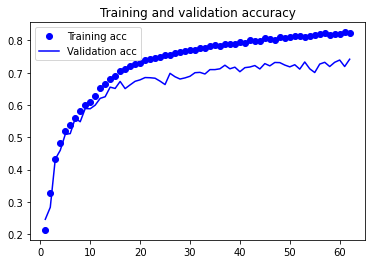

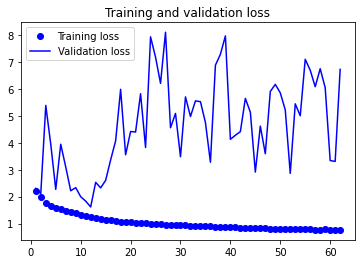

In [11]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
#Checkpoint = ModelCheckpoint("3DCovBest.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

#model = models.load_model('F:\\training3000\\pngs_thicknesses_model_L2.h5')
#model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['acc'])


history = model.fit(training_seq, 
                    epochs=100, 
                    validation_data = (val_images, val_lab), 
                    callbacks=[EarlyStop], 
                    workers = 16, 
                    shuffle = True,
                    use_multiprocessing = False)

#model.save('3DCovLast.h5')

#test_loss, test_acc = model.evaluate(test_images, test_lab)

#with open('3DCovPICKLE', 'wb') as file_pi: pickle.dump(history.history, file_pi)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [12]:
model.save('Conv_seq_36_3000_3M.h5')